# Assignment 9


Model Notes

- Stride = 2 implemented in last layer of block 2
- Depthwise separable convolution implemented in block 3
- Dilated convolution implemented in block 4
- Global Average Pooling implemented after block 4
- Output block has fully connected layers


## Mount Drive


In [1]:
# Mount google drive if running on colab

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/S9

Mounted at /content/drive
/content/drive/MyDrive/S9


## Import Libraries


In [2]:
# Import necessary modules (external libs)
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim

# from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary

In [3]:
# Import user defined modules
from dataset import split_cifar_data, apply_cifar_image_transformations
from model import Assignment9 as Net
from model import test_model, train_model
from utils import get_device, save_model
from visualize import (
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

In [4]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


## Data Transformations


In [5]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()

# Use precomputed values for mean and standard deviation of the dataset
cifar_mean = (0.4915, 0.4823, 0.4468)
cifar_std = (0.2470, 0.2435, 0.2616)

# cutout needs to be half of the image size
cutout_size = 16

train_transforms, test_transforms = apply_cifar_image_transformations(
    mean=cifar_mean, std=cifar_std, cutout_size=cutout_size
)

## Train/Test Split


In [8]:
data_path = "../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = split_cifar_data(data_path, train_transforms, test_transforms)

Train and test data path: ../data



100%|██████████| 170498071/170498071 [00:13<00:00, 12319783.66it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transforms applied on the dataset



## Dataloaders


In [9]:
# Set seed value for reproducibility
seed = 8

# For reproducibility
torch.manual_seed(seed)

if device_support == "cuda":
    torch.cuda.manual_seed(seed)

batch_size = 128

# calculate the number of workers
num_workers = (os.cpu_count() - 1) if os.cpu_count() > 3 else 2

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

In [10]:
# Create class labels
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Convert classes to propercase
classes = tuple([c.capitalize() for c in classes])
print(classes)

('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


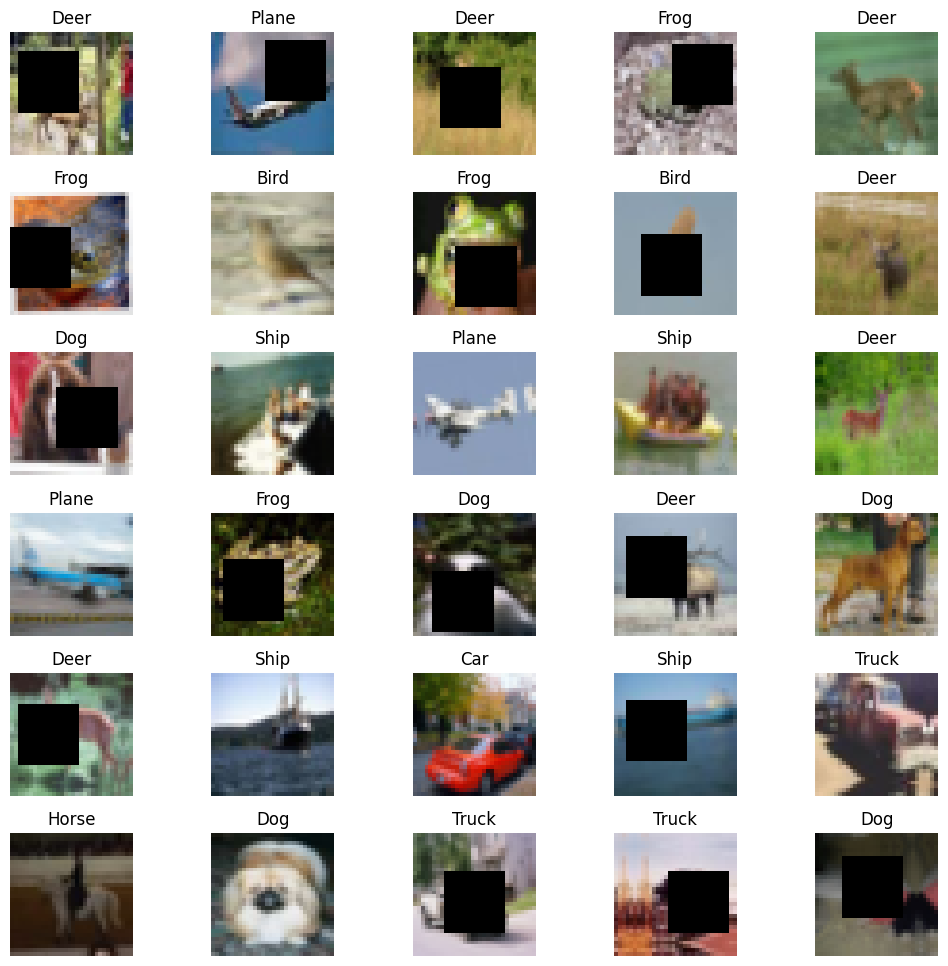

In [11]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [12]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# Print the model summary by specifying the input size
summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

torch.Size([2, 12, 32, 32])
torch.Size([2, 24, 16, 16])
torch.Size([2, 32, 16, 16])
torch.Size([2, 64, 14, 14])
torch.Size([2, 64, 1, 1])
torch.Size([2, 64])
torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
           Dropout-3            [-1, 8, 32, 32]               0
       BatchNorm2d-4            [-1, 8, 32, 32]              16
            Conv2d-5            [-1, 8, 32, 32]             576
              ReLU-6            [-1, 8, 32, 32]               0
           Dropout-7            [-1, 8, 32, 32]               0
       BatchNorm2d-8            [-1, 8, 32, 32]              16
            Conv2d-9           [-1, 12, 32, 32]             864
             ReLU-10           [-1, 12, 32, 32]               0
          Dropout-11           [-1, 12, 32, 32]      

## Metric Initialisation


In [13]:
# Data to plot accuracy and loss graphs

# Hold test and train losses in a list
train_losses = []
test_losses = []
# Hold test and train accuracies in a list
train_acc = []
test_acc = []
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

## Train and Test


In [14]:
# Specify the number of epochs
num_epochs = 50

# Expected accuracy
expected_accuracy = 85.0

# Create optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define criteria function
criterion = F.nll_loss

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.1,
    steps_per_epoch=len(train_data),
    epochs=num_epochs,
    verbose=False,
)

print(f"\n\nBatch size: {batch_size}, Total epochs: {num_epochs}\n\n")
# Run the model for num_epochs
for epoch in range(1, num_epochs + 1):
    # Print the current epoch
    print(f"Epoch {epoch}")

    # Train the model
    train_model(
        model, device, train_loader, optimizer, criterion, train_acc, train_losses
    )

    # Test the model
    test_model(
        model,
        device,
        test_loader,
        criterion,
        test_acc,
        test_losses,
        misclassified_image_data,
    )

    # Check if the accuracy is the best accuracy till now
    # Save the model if you get the best test accuracy
    if max(test_acc) == test_acc[-1]:
        print("Saving the model as best test accuracy till now is achieved!")
        save_model(
            epoch,
            model,
            optimizer,
            scheduler,
            batch_size,
            criterion,
            file_name="model_best_epoch.pth",
        )

    scheduler.step()
    # # # Line break before next epoch
    print("\n")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "




Batch size: 128, Total epochs: 50


Epoch 1


Train: Loss=1.5733, Batch_id=390, Accuracy=31.57: 100%|██████████| 391/391 [00:18<00:00, 21.21it/s]


Test set: Average loss: 1.4630, Accuracy: 4415/10000 (44.15%)
Saving the model as best test accuracy till now is achieved!


Epoch 2


Train: Loss=1.2017, Batch_id=390, Accuracy=46.16: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


Test set: Average loss: 1.2441, Accuracy: 5464/10000 (54.64%)
Saving the model as best test accuracy till now is achieved!


Epoch 3


Train: Loss=1.4209, Batch_id=390, Accuracy=53.13: 100%|██████████| 391/391 [00:19<00:00, 20.54it/s]


Test set: Average loss: 1.0453, Accuracy: 6230/10000 (62.30%)
Saving the model as best test accuracy till now is achieved!


Epoch 4


Train: Loss=1.1496, Batch_id=390, Accuracy=57.07: 100%|██████████| 391/391 [00:17<00:00, 22.40it/s]


Test set: Average loss: 0.9650, Accuracy: 6569/10000 (65.69%)
Saving the model as best test accuracy till now is achieved!


Epoch 5


Train: Loss=0.9233, Batch_id=390, Accuracy=60.23: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s]


Test set: Average loss: 0.8685, Accuracy: 6945/10000 (69.45%)
Saving the model as best test accuracy till now is achieved!


Epoch 6


Train: Loss=1.0836, Batch_id=390, Accuracy=62.34: 100%|██████████| 391/391 [00:17<00:00, 22.51it/s]


Test set: Average loss: 0.8319, Accuracy: 7047/10000 (70.47%)
Saving the model as best test accuracy till now is achieved!


Epoch 7


Train: Loss=1.0130, Batch_id=390, Accuracy=64.72: 100%|██████████| 391/391 [00:17<00:00, 22.50it/s]


Test set: Average loss: 0.7636, Accuracy: 7329/10000 (73.29%)
Saving the model as best test accuracy till now is achieved!


Epoch 8


Train: Loss=0.9702, Batch_id=390, Accuracy=65.61: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s]


Test set: Average loss: 0.7202, Accuracy: 7469/10000 (74.69%)
Saving the model as best test accuracy till now is achieved!


Epoch 9


Train: Loss=0.8912, Batch_id=390, Accuracy=67.31: 100%|██████████| 391/391 [00:17<00:00, 22.29it/s]


Test set: Average loss: 0.6942, Accuracy: 7586/10000 (75.86%)
Saving the model as best test accuracy till now is achieved!


Epoch 10


Train: Loss=0.9452, Batch_id=390, Accuracy=68.26: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s]


Test set: Average loss: 0.6705, Accuracy: 7644/10000 (76.44%)
Saving the model as best test accuracy till now is achieved!


Epoch 11


Train: Loss=0.8852, Batch_id=390, Accuracy=69.08: 100%|██████████| 391/391 [00:17<00:00, 22.35it/s]


Test set: Average loss: 0.6601, Accuracy: 7739/10000 (77.39%)
Saving the model as best test accuracy till now is achieved!


Epoch 12


Train: Loss=1.0252, Batch_id=390, Accuracy=70.01: 100%|██████████| 391/391 [00:17<00:00, 22.47it/s]


Test set: Average loss: 0.6282, Accuracy: 7778/10000 (77.78%)
Saving the model as best test accuracy till now is achieved!


Epoch 13


Train: Loss=0.8491, Batch_id=390, Accuracy=70.64: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]


Test set: Average loss: 0.6153, Accuracy: 7831/10000 (78.31%)
Saving the model as best test accuracy till now is achieved!


Epoch 14


Train: Loss=0.5917, Batch_id=390, Accuracy=71.24: 100%|██████████| 391/391 [00:17<00:00, 22.26it/s]


Test set: Average loss: 0.6050, Accuracy: 7936/10000 (79.36%)
Saving the model as best test accuracy till now is achieved!


Epoch 15


Train: Loss=0.7349, Batch_id=390, Accuracy=71.57: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s]


Test set: Average loss: 0.5884, Accuracy: 7912/10000 (79.12%)


Epoch 16


Train: Loss=0.8000, Batch_id=390, Accuracy=72.36: 100%|██████████| 391/391 [00:17<00:00, 22.36it/s]


Test set: Average loss: 0.5627, Accuracy: 8030/10000 (80.30%)
Saving the model as best test accuracy till now is achieved!


Epoch 17


Train: Loss=1.1241, Batch_id=390, Accuracy=72.58: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]


Test set: Average loss: 0.5549, Accuracy: 8060/10000 (80.60%)
Saving the model as best test accuracy till now is achieved!


Epoch 18


Train: Loss=0.6498, Batch_id=390, Accuracy=73.31: 100%|██████████| 391/391 [00:17<00:00, 22.50it/s]


Test set: Average loss: 0.5450, Accuracy: 8100/10000 (81.00%)
Saving the model as best test accuracy till now is achieved!


Epoch 19


Train: Loss=1.0104, Batch_id=390, Accuracy=73.50: 100%|██████████| 391/391 [00:17<00:00, 22.30it/s]


Test set: Average loss: 0.5320, Accuracy: 8156/10000 (81.56%)
Saving the model as best test accuracy till now is achieved!


Epoch 20


Train: Loss=0.7962, Batch_id=390, Accuracy=73.78: 100%|██████████| 391/391 [00:18<00:00, 21.50it/s]


Test set: Average loss: 0.5299, Accuracy: 8179/10000 (81.79%)
Saving the model as best test accuracy till now is achieved!


Epoch 21


Train: Loss=0.8449, Batch_id=390, Accuracy=74.21: 100%|██████████| 391/391 [00:17<00:00, 22.86it/s]


Test set: Average loss: 0.5266, Accuracy: 8205/10000 (82.05%)
Saving the model as best test accuracy till now is achieved!


Epoch 22


Train: Loss=0.7597, Batch_id=390, Accuracy=74.56: 100%|██████████| 391/391 [00:17<00:00, 22.27it/s]


Test set: Average loss: 0.5080, Accuracy: 8229/10000 (82.29%)
Saving the model as best test accuracy till now is achieved!


Epoch 23


Train: Loss=0.9268, Batch_id=390, Accuracy=75.08: 100%|██████████| 391/391 [00:17<00:00, 22.78it/s]


Test set: Average loss: 0.5085, Accuracy: 8264/10000 (82.64%)
Saving the model as best test accuracy till now is achieved!


Epoch 24


Train: Loss=0.6913, Batch_id=390, Accuracy=75.06: 100%|██████████| 391/391 [00:16<00:00, 23.17it/s]


Test set: Average loss: 0.5017, Accuracy: 8258/10000 (82.58%)


Epoch 25


Train: Loss=0.9082, Batch_id=390, Accuracy=75.34: 100%|██████████| 391/391 [00:18<00:00, 21.53it/s]


Test set: Average loss: 0.5197, Accuracy: 8182/10000 (81.82%)


Epoch 26


Train: Loss=0.7258, Batch_id=390, Accuracy=75.43: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s]


Test set: Average loss: 0.4952, Accuracy: 8283/10000 (82.83%)
Saving the model as best test accuracy till now is achieved!


Epoch 27


Train: Loss=0.5777, Batch_id=390, Accuracy=75.82: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s]


Test set: Average loss: 0.5076, Accuracy: 8239/10000 (82.39%)


Epoch 28


Train: Loss=0.5919, Batch_id=390, Accuracy=76.21: 100%|██████████| 391/391 [00:17<00:00, 22.70it/s]


Test set: Average loss: 0.4781, Accuracy: 8329/10000 (83.29%)
Saving the model as best test accuracy till now is achieved!


Epoch 29


Train: Loss=0.5337, Batch_id=390, Accuracy=76.24: 100%|██████████| 391/391 [00:16<00:00, 23.01it/s]


Test set: Average loss: 0.4761, Accuracy: 8325/10000 (83.25%)


Epoch 30


Train: Loss=0.8455, Batch_id=390, Accuracy=76.52: 100%|██████████| 391/391 [00:17<00:00, 22.45it/s]


Test set: Average loss: 0.4758, Accuracy: 8367/10000 (83.67%)
Saving the model as best test accuracy till now is achieved!


Epoch 31


Train: Loss=0.8145, Batch_id=390, Accuracy=76.38: 100%|██████████| 391/391 [00:17<00:00, 22.98it/s]


Test set: Average loss: 0.4752, Accuracy: 8317/10000 (83.17%)


Epoch 32


Train: Loss=0.8853, Batch_id=390, Accuracy=76.90: 100%|██████████| 391/391 [00:17<00:00, 22.95it/s]


Test set: Average loss: 0.4792, Accuracy: 8362/10000 (83.62%)


Epoch 33


Train: Loss=0.7404, Batch_id=390, Accuracy=76.99: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]


Test set: Average loss: 0.4630, Accuracy: 8389/10000 (83.89%)
Saving the model as best test accuracy till now is achieved!


Epoch 34


Train: Loss=0.5390, Batch_id=390, Accuracy=76.89: 100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


Test set: Average loss: 0.4709, Accuracy: 8393/10000 (83.93%)
Saving the model as best test accuracy till now is achieved!


Epoch 35


Train: Loss=0.8644, Batch_id=390, Accuracy=77.14: 100%|██████████| 391/391 [00:17<00:00, 22.56it/s]


Test set: Average loss: 0.4500, Accuracy: 8422/10000 (84.22%)
Saving the model as best test accuracy till now is achieved!


Epoch 36


Train: Loss=0.5737, Batch_id=390, Accuracy=77.35: 100%|██████████| 391/391 [00:17<00:00, 22.64it/s]


Test set: Average loss: 0.4513, Accuracy: 8414/10000 (84.14%)


Epoch 37


Train: Loss=0.6044, Batch_id=390, Accuracy=77.58: 100%|██████████| 391/391 [00:16<00:00, 23.16it/s]


Test set: Average loss: 0.4559, Accuracy: 8445/10000 (84.45%)
Saving the model as best test accuracy till now is achieved!


Epoch 38


Train: Loss=0.5943, Batch_id=390, Accuracy=77.91: 100%|██████████| 391/391 [00:18<00:00, 21.42it/s]


Test set: Average loss: 0.4341, Accuracy: 8480/10000 (84.80%)
Saving the model as best test accuracy till now is achieved!


Epoch 39


Train: Loss=0.4412, Batch_id=390, Accuracy=77.92: 100%|██████████| 391/391 [00:17<00:00, 22.85it/s]


Test set: Average loss: 0.4486, Accuracy: 8424/10000 (84.24%)


Epoch 40


Train: Loss=0.5851, Batch_id=390, Accuracy=77.90: 100%|██████████| 391/391 [00:16<00:00, 23.31it/s]


Test set: Average loss: 0.4345, Accuracy: 8483/10000 (84.83%)
Saving the model as best test accuracy till now is achieved!


Epoch 41


Train: Loss=0.6278, Batch_id=390, Accuracy=78.20: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]


Test set: Average loss: 0.4402, Accuracy: 8469/10000 (84.69%)


Epoch 42


Train: Loss=0.5460, Batch_id=390, Accuracy=78.53: 100%|██████████| 391/391 [00:17<00:00, 22.21it/s]


Test set: Average loss: 0.4519, Accuracy: 8438/10000 (84.38%)


Epoch 43


Train: Loss=0.6400, Batch_id=390, Accuracy=78.46: 100%|██████████| 391/391 [00:18<00:00, 21.51it/s]


Test set: Average loss: 0.4300, Accuracy: 8486/10000 (84.86%)
Saving the model as best test accuracy till now is achieved!


Epoch 44


Train: Loss=0.4041, Batch_id=390, Accuracy=78.55: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]


Test set: Average loss: 0.4308, Accuracy: 8507/10000 (85.07%)
Saving the model as best test accuracy till now is achieved!


Epoch 45


Train: Loss=0.6091, Batch_id=390, Accuracy=78.54: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s]


Test set: Average loss: 0.4379, Accuracy: 8487/10000 (84.87%)


Epoch 46


Train: Loss=0.7416, Batch_id=390, Accuracy=78.54: 100%|██████████| 391/391 [00:17<00:00, 22.28it/s]


Test set: Average loss: 0.4268, Accuracy: 8534/10000 (85.34%)
Saving the model as best test accuracy till now is achieved!


Epoch 47


Train: Loss=0.5294, Batch_id=390, Accuracy=78.74: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]


Test set: Average loss: 0.4265, Accuracy: 8526/10000 (85.26%)


Epoch 48


Train: Loss=0.6561, Batch_id=390, Accuracy=78.98: 100%|██████████| 391/391 [00:18<00:00, 21.38it/s]


Test set: Average loss: 0.4279, Accuracy: 8525/10000 (85.25%)


Epoch 49


Train: Loss=0.7465, Batch_id=390, Accuracy=79.08: 100%|██████████| 391/391 [00:17<00:00, 22.34it/s]


Test set: Average loss: 0.4297, Accuracy: 8504/10000 (85.04%)


Epoch 50


Train: Loss=0.6341, Batch_id=390, Accuracy=79.05: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]


Test set: Average loss: 0.4286, Accuracy: 8501/10000 (85.01%)




In [15]:
# Pretty print train and test accuracy and loss values for each epoch
for i in range(num_epochs):
    print(
        f"Epoch: {i+1:02d}, Train Loss: {train_losses[i]:.4f}, Test Loss: {test_losses[i]:.4f}, Train Accuracy: {train_acc[i]:.4f}, Test Accuracy: {test_acc[i]:.4f}"
    )

Epoch: 01, Train Loss: 1.8048, Test Loss: 1.4630, Train Accuracy: 31.5660, Test Accuracy: 44.1500
Epoch: 02, Train Loss: 1.4610, Test Loss: 1.2441, Train Accuracy: 46.1600, Test Accuracy: 54.6400
Epoch: 03, Train Loss: 1.2917, Test Loss: 1.0453, Train Accuracy: 53.1320, Test Accuracy: 62.3000
Epoch: 04, Train Loss: 1.1894, Test Loss: 0.9650, Train Accuracy: 57.0660, Test Accuracy: 65.6900
Epoch: 05, Train Loss: 1.1100, Test Loss: 0.8685, Train Accuracy: 60.2280, Test Accuracy: 69.4500
Epoch: 06, Train Loss: 1.0515, Test Loss: 0.8319, Train Accuracy: 62.3400, Test Accuracy: 70.4700
Epoch: 07, Train Loss: 0.9953, Test Loss: 0.7636, Train Accuracy: 64.7220, Test Accuracy: 73.2900
Epoch: 08, Train Loss: 0.9637, Test Loss: 0.7202, Train Accuracy: 65.6100, Test Accuracy: 74.6900
Epoch: 09, Train Loss: 0.9258, Test Loss: 0.6942, Train Accuracy: 67.3060, Test Accuracy: 75.8600
Epoch: 10, Train Loss: 0.8994, Test Loss: 0.6705, Train Accuracy: 68.2580, Test Accuracy: 76.4400
Epoch: 11, Train Los

## Metrics


Expected accuracy: 85.0%
Plotting accuracy and loss graphs.


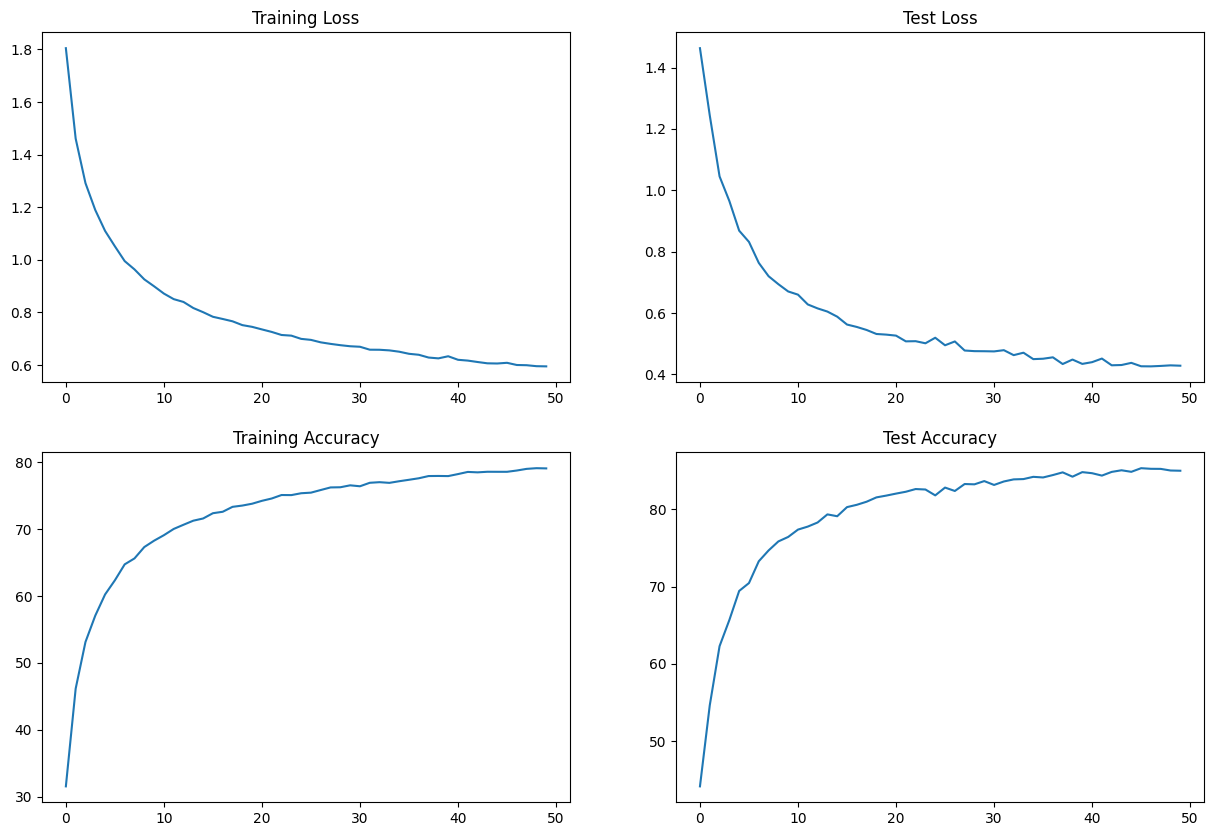

In [16]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {expected_accuracy}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(train_losses, train_acc, test_losses, test_acc)
plt.show()

## Save model


In [17]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch,
    model,
    optimizer,
    scheduler,
    batch_size,
    criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


## Show incorrect images


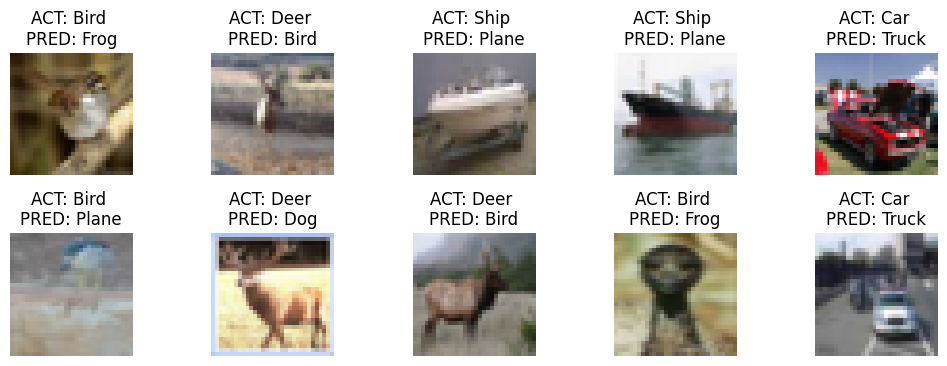

In [18]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()